In [1]:
!pip install -qq scikit-image captum Pillow pydicom torchinfo torchview

In [2]:
import os
import random
import re
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from PIL import Image, ImageOps
import requests

# Google
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive/')

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Pydicom - Load DCM Files
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut

# Scikit-image
from skimage.io import imread

# Pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet18, resnet50
from torchinfo import summary
from torchview import draw_graph

# Captum
import captum
from captum.attr import Saliency, LayerGradCam, Occlusion, LayerAttribution
from captum.attr import visualization as viz

print(captum.__version__)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
0.8.0


In [ ]:
# Load the Google Sheet using Pandas.
sheet_id = "$YOUR_OWN_SHEET_ID"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [4]:
df = pd.read_csv(url)

In [5]:
df.head()

,patient_id,path,new_path,testing_path_url,testing_new_path,testing_herniated_disc,testing_no_stenosis,testing_thecal_sac,label_id,label_name,herniated_disc,no_stenosis,facet_joint,foramen,thecal_sac
0,1,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/1/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/200/,200.0,202.0,213.0,/Labeller 1/,/Herniated Disc/,1.0,2.0,20.0,13.0,12.0
1,2,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/2/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/202/,NaN,NaN,NaN,/Labeller 2/,/No Stenosis/,3.0,9.0,22.0,15.0,14.0
2,3,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/3/,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/213/,NaN,NaN,NaN,/Labeller 3/,/Thecal Sac/,4.0,10.0,26.0,17.0,16.0
3,4,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/4/,NaN,NaN,NaN,NaN,NaN,/Labeller 4/,/Foramen/,5.0,18.0,30.0,19.0,23.0
4,5,/content/drive/MyDrive/thesis/Datasets/lumbar_...,/5/,NaN,NaN,NaN,NaN,NaN,/Labeller 5/,/Facet Joint/,6.0,24.0,52.0,21.0,25.0


In [6]:
# Define the labels.

def get_label(selected_label_name: str):
  label_name = list(df['label_name'])

  for i in range(0, len(label_name)):
    if '/Herniated Disc/' in selected_label_name:
      return 'Herniated Disc'
    if '/No Stenosis/' in selected_label_name:
      return 'No Stenosis'
    if '/Thecal Sac/' in selected_label_name:
      return 'Thecal Sac'
    if '/Foramen/' in selected_label_name:
      return 'Foramen'
    if '/Facet Joint/' in selected_label_name:
      return 'Facet Joint'

print(get_label('/Herniated Disc/'))

Herniated Disc


In [ ]:
# load all the MRIs on the basis of patient_ids.

training_dataset_path = '/preprocessed_images/final_preprocessed/training'
testing_dataset_path = '/preprocessed_images/final_preprocessed/testing'
paths = list(df['new_path'])

def load_dataset(dataset_path: str):
  mri_dcm = []
  mri_dcm.clear()

  dataset_list = list(Path(dataset_path).rglob("*.jpg" ))
  for fileName in dataset_list:
    try:
      file_size = os.path.getsize(fileName)
      if file_size > 0:
        # for i in paths:
        # if i in str(fileName):
            # patient_id = str(re.findall('\d+',i)[0])
            # new_data = {'filePath': str(fileName), 'patient_id': patient_id}
        new_data = {'filePath': str(fileName), 'label': get_label(str(fileName))}
        mri_dcm.append(new_data)
    except FileNotFoundError as e:
      continue
  return mri_dcm

training_dataset = load_dataset(training_dataset_path)
testing_dataset = load_dataset(testing_dataset_path)

Show the total number of training dataset available

In [8]:
len(training_dataset), len(testing_dataset)

(4629, 1158)

Creating own Dataset `Class` to load our own datasets.

In [9]:
def get_label_no(selected_label_name: str):
  if selected_label_name == 'Herniated Disc':
    return 0
  if selected_label_name == 'Thecal Sac':
    return 1
  # if selected_label_name == 'Foramen':
  #   return 2
  # if selected_label_name == 'Facet Joint':
  #   return 3
  if selected_label_name == 'No Stenosis':
    return 2

In [10]:
class LumbarSpinalDataset(Dataset):
  def __init__(self, dataset = None, transform=None, image_size = None):
    self.labels = dataset
    self.transform = transform
    self.image_size = image_size

    # self.classes = ['Herniated Disc', 'No Stenosis', 'Thecal Sac', 'Foramen', 'Facet Joint']
    self.classes = ['Herniated Disc', 'No Stenosis', 'Thecal Sac']
    self.load_dataset()

  def load_dataset(self):
    image_path = []

    for i in range(0, len(training_dataset)):
      image_path.append((training_dataset[i]['filePath'], get_label_no(training_dataset[i]['label'])))

    for i in range(0, len(testing_dataset)):
      image_path.append((testing_dataset[i]['filePath'], get_label_no(testing_dataset[i]['label'])))

    self.labels = image_path

  def normalize(self, image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    image = transform(image)
    return image

  def __getitem__(self, index):
    fpath, target = self.labels[index]
    # fpath = self.labels[idx]
    image_array = imread(fpath, as_gray=True)
    # image_array = self.normalize_image(image_array)
    image_array = self.normalize(image_array)
    # data = torch.from_numpy(image_array)
    data = image_array.type(torch.FloatTensor)
    # data = torch.unsqueeze(data, 0)
    data = transforms.Resize((self.image_size, self.image_size))(data)

    return data, target

  def __len__(self):
    return len(self.labels)

In [11]:
dataset = LumbarSpinalDataset(image_size=256)

In [12]:
type(dataset)

__main__.LumbarSpinalDataset

### Spliting the `Dataset` Randomly

For this we are splitting our dataset into training, validation, and testing by 80%, 10% and 10% respectively.

In [13]:
train_fraction = 0.9
val_fraction = 0.05
test_fraction = 0.05
dataset_size = len(dataset)
print(dataset_size)

num_train = int(train_fraction * dataset_size)
num_validation = int(val_fraction * dataset_size)
num_test = dataset_size - num_train - num_validation

print(num_train, num_validation, num_test)

train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(
                                 dataset, [num_train, num_validation, num_test],
                                 generator=torch.Generator().manual_seed(42))
print(type(train_dataset))
print(len(train_dataset), len(validation_dataset), len(test_dataset))

5787
5208 289 290
<class 'torch.utils.data.dataset.Subset'>
5208 289 290


Check do we conneted with the GPU or not.

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataloaders

It is hard for us to train our model by giving it one by one images in each epoch. So, this procedure is quite slow, for this we need to make sure that in each epoch we will pass a batch of images instead of a single image. That is why, we are using `Dataloaders` to load our data in `batches`.

In [15]:
train_batch_size = 200
eval_batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size)

In [16]:
len(train_dataloader), len(validation_dataloader), len(test_dataloader)

(27, 29, 29)

We need to make sure that in every systems the random values must be same.

## Load the Predictation Data

In [ ]:
image_paths = ['/preprocessed_images/testing_preprocessed/testing/Herniated Disc/image_9.jpg', \
               '//preprocessed_images/testing_preprocessed/testing/Herniated Disc/image_32.jpg', \
               '/preprocessed_images/testing_preprocessed/testing/No Stenosis/image_49.jpg', \
               '/preprocessed_images/testing_preprocessed/testing/No Stenosis/image_60.jpg', \
               '/preprocessed_images/testing_preprocessed/testing/Thecal Sac/image_90.jpg', \
               '/preprocessed_images/testing_preprocessed/testing/Thecal Sac/image_105.jpg']

In [18]:
# Model expects 400x400 1-channel (grayscale) images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(degrees=10),  # Random rotation
    transforms.ToTensor(),  # Shape: [1, 400, 400]
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Adjust based on your model
])

# For grayscale normalization (adjust mean/std if needed)
norm_transform = transforms.Normalize(mean=[0.5], std=[0.5])  # Maps [0,1] → [-1,1]

original_img = []
input_img = []
new_img = []

original_img.clear()
input_img.clear()
new_img.clear()

for i in range(len(image_paths)):
    # Load image and apply transforms
    img = Image.open(image_paths[i]).convert('L')  # 'L' mode for grayscale
    transformed = transform(img)  # [1, 400, 400]
    new_img.append(transformed)

    # Normalize and store
    transformed*= (1.0/transformed.max())

    # Normalize and store
    normalized = norm_transform(transformed).unsqueeze(0)  # [1, 1, 400, 400]
    input_img.append(normalized)

    # For visualization, denormalize and convert to numpy
    denormalized = (transformed * 0.5) + 0.5  # Reverse normalization: [-1,1] → [0,1]
    original_img.append(denormalized.squeeze().cpu().numpy())  # [400, 400]

In [19]:
len(input_img), input_img[5].shape

(6, torch.Size([1, 1, 400, 400]))

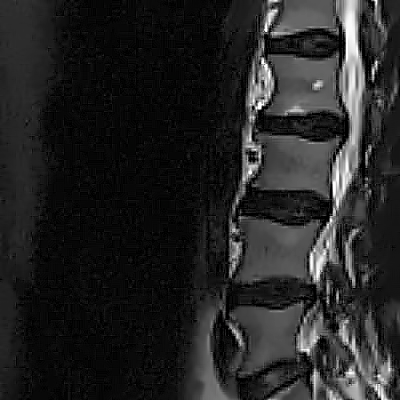

In [ ]:
import cv2
import numpy as np

image = cv2.imread('/preprocessed_images/testing_preprocessed/testing/Herniated Disc/image_9.jpg')

sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(image, 0 , sharpen_kernel)

deblurred = cv2.fastNlMeansDenoisingColored(sharpen,None,10,10,7,21)

cv2_imshow(deblurred)

In [21]:
input_img[0].shape

torch.Size([1, 1, 400, 400])

In [22]:
type(input_img[0])

torch.Tensor

In [23]:

# batch_index, inputs, targets = None, None, None

# For training visualization later
train_accs = []
val_accs = []
test_accs = []

y_pred_true = []
y_pred = []
train_losses = []  # New: Track training loss per epoch
val_losses = []    # New: Track validation loss per epoch

def train_model(model, num_epochs, criterion, optimizer, batch_size):
  # clear all lists
  train_accs.clear()
  val_accs.clear()
  test_accs.clear()
  y_pred_true.clear()
  y_pred.clear()
  train_losses.clear()
  val_losses.clear()

  best_validation_accuracy = 0
  best_testing_accuracy = 0

  train_loss = 0.0
  val_epoch_loss = 0.0

  running_loss = 0.0
  running_corrects = 0
  early_stops = False

  # training loop
  for epoch in range(num_epochs):

    if early_stops:
      break

    # Set a network to train mode, so that its parameters can be changed
    model.train()
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # print training info
    print("Epoch {}:".format(epoch))

    # Statistics needed to compute classification accuracy.
    # the total number of image examples trained on
    total_train_examples = 0

    # the number of examples classified correctly
    num_correct_train = 0

    # iterate over the training set once
    # for batch_index, (inputs) in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size):
    # for batch_index, inputs, targets in tqdm(enumerate(train_dataloader), total=len(train_dataset) // train_batch_size, desc="Training Process"):
    for batch_index, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataset) // batch_size, desc="Training Model"):
      inputs = inputs.to(device)
      targets = targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      predictation = model(inputs)
      loss = criterion(predictation, targets)
      loss.backward()
      optimizer.step()

      _, predicted_class = predictation.max(1)
      total_train_examples += predicted_class.size(0)
      num_correct_train += predicted_class.eq(targets).sum().item()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(predicted_class == targets)

    train_acc = num_correct_train / total_train_examples
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    train_accs.append(train_acc)

    train_loss = running_loss / len(train_dataset)  # Average training loss
    epoch_acc = running_corrects.double() / len(train_dataloader)
    print(f'Train Loss: {train_loss:.4f} Acc: {epoch_acc:.4f}')
    train_losses.append(train_loss)  # Store training loss

    total_val_examples = 0
    num_correct_val = 0
    val_loss = 0.0


    total_test_examples = 0
    num_correct_test = 0

    with torch.no_grad():
      for batch_index, (inputs, targets) in tqdm(enumerate(validation_dataloader), total=len(validation_dataset) // eval_batch_size, desc="Validation"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        predictation = model(inputs)

        # Track validation loss
        loss = criterion(predictation, targets)
        val_loss += loss.item() * inputs.size(0)

        _, predicted_class = predictation.max(1)
        total_test_examples += predicted_class.size(0)
        num_correct_test += predicted_class.eq(targets).sum().item()
        y_pred.append(predicted_class.cpu().numpy())
        y_pred_true.append(targets.cpu().numpy())

    # Compute epoch validation loss/accuracy
    val_epoch_loss = val_loss / len(validation_dataset)  # Average validation loss
    test_acc = num_correct_test / total_test_examples
    print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {test_acc:.4f}")
    test_accs.append(test_acc)
    val_losses.append(val_epoch_loss)  # Store validation loss


    if test_acc > best_testing_accuracy:
      best_testing_accuracy = test_acc
      # torch.save(net.state_dict(), "best_model.pth")
      print("accuracy improved, saving model")
      net_copy = deepcopy(model)

    # Early stopping condition
    if test_acc >= 0.80:  # 80% threshold
      print(f"\nEarly stopping triggered! Validation accuracy reached {test_acc*100:.2f}%")
      early_stop = True

  return net_copy, test_acc, train_acc

In [25]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()

        # Convolutional blocks
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(1, 8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Subsequent blocks with increasing filters
            self._make_block(8, 16),
            self._make_block(16, 32),
            self._make_block(32, 64),
            self._make_block(64, 128),
            self._make_block(128, 256),
            # self._make_block(256, 512),
            # Final processing
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1)  # Reduces spatial dimensions to 1x1
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [26]:
learning_rate = 1e-3
num_epochs = 100
num_classes = 3
input_size = 400 * 400
batch_size = 64

model = CNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
net_copy, test_acc, train_acc = train_model(model, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, batch_size=batch_size)

Epoch [1/100]
Epoch 0:


Training Model:  33%|███▎      | 27/81 [00:37<01:15,  1.39s/it]


Train Loss: 0.0000 | Train Acc: 0.4015
Train Loss: 1.0766 Acc: 77.4444


Validation: 29it [00:01, 17.92it/s]                        


Val Loss: 1.0821 | Val Acc: 0.4256
accuracy improved, saving model
Epoch [2/100]
Epoch 1:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.07s/it]


Train Loss: 1.0766 | Train Acc: 0.4482
Train Loss: 2.1286 Acc: 163.8889


Validation: 29it [00:01, 21.22it/s]                        


Val Loss: 1.0937 | Val Acc: 0.4118
Epoch [3/100]
Epoch 2:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 2.1286 | Train Acc: 0.4553
Train Loss: 3.1817 Acc: 251.7037


Validation: 29it [00:01, 21.57it/s]                        


Val Loss: 1.0670 | Val Acc: 0.4221
Epoch [4/100]
Epoch 3:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 3.1817 | Train Acc: 0.5033
Train Loss: 4.2002 Acc: 348.7778


Validation: 29it [00:01, 21.39it/s]                        


Val Loss: 1.0256 | Val Acc: 0.5087
accuracy improved, saving model
Epoch [5/100]
Epoch 4:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 4.2002 | Train Acc: 0.5684
Train Loss: 5.1677 Acc: 458.4074


Validation: 29it [00:01, 18.57it/s]                        


Val Loss: 1.0194 | Val Acc: 0.4948
Epoch [6/100]
Epoch 5:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 5.1677 | Train Acc: 0.6179
Train Loss: 6.0937 Acc: 577.5926


Validation: 29it [00:01, 21.22it/s]                        


Val Loss: 1.0325 | Val Acc: 0.4879
Epoch [7/100]
Epoch 6:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 6.0937 | Train Acc: 0.6071
Train Loss: 7.0238 Acc: 694.7037


Validation: 29it [00:01, 21.60it/s]                        


Val Loss: 1.0025 | Val Acc: 0.5121
accuracy improved, saving model
Epoch [8/100]
Epoch 7:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 7.0238 | Train Acc: 0.6703
Train Loss: 7.8990 Acc: 824.0000


Validation: 29it [00:01, 20.87it/s]                        


Val Loss: 1.0115 | Val Acc: 0.5087
Epoch [9/100]
Epoch 8:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 7.8990 | Train Acc: 0.7099
Train Loss: 8.7342 Acc: 960.9259


Validation: 29it [00:01, 19.24it/s]                        


Val Loss: 0.9451 | Val Acc: 0.5952
accuracy improved, saving model
Epoch [10/100]
Epoch 9:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 8.7342 | Train Acc: 0.7331
Train Loss: 9.5509 Acc: 1102.3333


Validation: 29it [00:01, 21.88it/s]                        


Val Loss: 0.9561 | Val Acc: 0.5744
Epoch [11/100]
Epoch 10:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 9.5509 | Train Acc: 0.7375
Train Loss: 10.3627 Acc: 1244.5926


Validation: 29it [00:01, 21.80it/s]                        


Val Loss: 0.9701 | Val Acc: 0.5571
Epoch [12/100]
Epoch 11:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 10.3627 | Train Acc: 0.7333
Train Loss: 11.1728 Acc: 1386.0370


Validation: 29it [00:01, 21.61it/s]                        


Val Loss: 0.9192 | Val Acc: 0.6228
accuracy improved, saving model
Epoch [13/100]
Epoch 12:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 11.1728 | Train Acc: 0.7830
Train Loss: 11.9393 Acc: 1537.0741


Validation: 29it [00:01, 18.59it/s]                        


Val Loss: 0.9535 | Val Acc: 0.5848
Epoch [14/100]
Epoch 13:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 11.9393 | Train Acc: 0.7675
Train Loss: 12.7183 Acc: 1685.1111


Validation: 29it [00:01, 21.78it/s]                        


Val Loss: 0.9316 | Val Acc: 0.6021
Epoch [15/100]
Epoch 14:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 12.7183 | Train Acc: 0.8109
Train Loss: 13.4572 Acc: 1841.5185


Validation: 29it [00:01, 21.79it/s]                        


Val Loss: 0.9502 | Val Acc: 0.5952
Epoch [16/100]
Epoch 15:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 13.4572 | Train Acc: 0.8289
Train Loss: 14.1807 Acc: 2001.4074


Validation: 29it [00:01, 21.74it/s]                        


Val Loss: 0.9410 | Val Acc: 0.5952
Epoch [17/100]
Epoch 16:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.02s/it]


Train Loss: 14.1807 | Train Acc: 0.8232
Train Loss: 14.9090 Acc: 2160.1852


Validation: 29it [00:01, 18.83it/s]                        


Val Loss: 0.8947 | Val Acc: 0.6505
accuracy improved, saving model
Epoch [18/100]
Epoch 17:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 14.9090 | Train Acc: 0.8625
Train Loss: 15.5982 Acc: 2326.5556


Validation: 29it [00:01, 21.47it/s]


Val Loss: 0.8904 | Val Acc: 0.6401
Epoch [19/100]
Epoch 18:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 15.5982 | Train Acc: 0.8525
Train Loss: 16.2938 Acc: 2491.0000


Validation: 29it [00:01, 21.90it/s]                        


Val Loss: 0.8765 | Val Acc: 0.6574
accuracy improved, saving model
Epoch [20/100]
Epoch 19:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 16.2938 | Train Acc: 0.8790
Train Loss: 16.9673 Acc: 2660.5556


Validation: 29it [00:01, 21.38it/s]                        


Val Loss: 0.8861 | Val Acc: 0.6609
accuracy improved, saving model
Epoch [21/100]
Epoch 20:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 16.9673 | Train Acc: 0.9075
Train Loss: 17.6132 Acc: 2835.5926


Validation: 29it [00:01, 18.64it/s]                        


Val Loss: 0.8750 | Val Acc: 0.6747
accuracy improved, saving model
Epoch [22/100]
Epoch 21:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 17.6132 | Train Acc: 0.8760
Train Loss: 18.2898 Acc: 3004.5556


Validation: 29it [00:01, 21.86it/s]


Val Loss: 0.9510 | Val Acc: 0.5779
Epoch [23/100]
Epoch 22:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 18.2898 | Train Acc: 0.7417
Train Loss: 19.0902 Acc: 3147.6296


Validation: 29it [00:01, 21.66it/s]                        


Val Loss: 0.9264 | Val Acc: 0.6125
Epoch [24/100]
Epoch 23:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 19.0902 | Train Acc: 0.8562
Train Loss: 19.7868 Acc: 3312.7778


Validation: 29it [00:01, 21.72it/s]                        


Val Loss: 0.8780 | Val Acc: 0.6644
Epoch [25/100]
Epoch 24:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 19.7868 | Train Acc: 0.8648
Train Loss: 20.4752 Acc: 3479.5926


Validation: 29it [00:01, 18.71it/s]                        


Val Loss: 0.8772 | Val Acc: 0.6505
Epoch [26/100]
Epoch 25:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 20.4752 | Train Acc: 0.9103
Train Loss: 21.1186 Acc: 3655.1852


Validation: 29it [00:01, 21.45it/s]                        


Val Loss: 0.8705 | Val Acc: 0.6713
Epoch [27/100]
Epoch 26:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 21.1186 | Train Acc: 0.8984
Train Loss: 21.7752 Acc: 3828.4815


Validation: 29it [00:01, 21.17it/s]                        


Val Loss: 0.9038 | Val Acc: 0.6367
Epoch [28/100]
Epoch 27:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 21.7752 | Train Acc: 0.8224
Train Loss: 22.5008 Acc: 3987.1111


Validation: 29it [00:01, 21.76it/s]                        


Val Loss: 0.9078 | Val Acc: 0.6298
Epoch [29/100]
Epoch 28:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 22.5008 | Train Acc: 0.8602
Train Loss: 23.1887 Acc: 4153.0370


Validation: 29it [00:01, 18.13it/s]                        


Val Loss: 0.8748 | Val Acc: 0.6747
Epoch [30/100]
Epoch 29:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 23.1887 | Train Acc: 0.8783
Train Loss: 23.8627 Acc: 4322.4444


Validation: 29it [00:01, 21.75it/s]                        


Val Loss: 0.9082 | Val Acc: 0.6228
Epoch [31/100]
Epoch 30:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 23.8627 | Train Acc: 0.8802
Train Loss: 24.5336 Acc: 4492.2222


Validation: 29it [00:01, 21.82it/s]                        


Val Loss: 0.8748 | Val Acc: 0.6678
Epoch [32/100]
Epoch 31:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 24.5336 | Train Acc: 0.8685
Train Loss: 25.2163 Acc: 4659.7407


Validation: 29it [00:01, 21.86it/s]                        


Val Loss: 0.8786 | Val Acc: 0.6644
Epoch [33/100]
Epoch 32:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 25.2163 | Train Acc: 0.9267
Train Loss: 25.8417 Acc: 4838.4815


Validation: 29it [00:01, 19.52it/s]                        


Val Loss: 0.8355 | Val Acc: 0.7093
accuracy improved, saving model
Epoch [34/100]
Epoch 33:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 25.8417 | Train Acc: 0.9447
Train Loss: 26.4504 Acc: 5020.7037


Validation: 29it [00:01, 20.51it/s]                        


Val Loss: 0.8481 | Val Acc: 0.6920
Epoch [35/100]
Epoch 34:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 26.4504 | Train Acc: 0.9092
Train Loss: 27.0928 Acc: 5196.0741


Validation: 29it [00:01, 21.96it/s]                        


Val Loss: 0.8719 | Val Acc: 0.6678
Epoch [36/100]
Epoch 35:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 27.0928 | Train Acc: 0.9046
Train Loss: 27.7412 Acc: 5370.5556


Validation: 29it [00:01, 21.58it/s]                        


Val Loss: 0.8708 | Val Acc: 0.6817
Epoch [37/100]
Epoch 36:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.02s/it]


Train Loss: 27.7412 | Train Acc: 0.8992
Train Loss: 28.3938 Acc: 5544.0000


Validation: 29it [00:01, 21.29it/s]                        


Val Loss: 0.8585 | Val Acc: 0.6713
Epoch [38/100]
Epoch 37:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 28.3938 | Train Acc: 0.8886
Train Loss: 29.0550 Acc: 5715.4074


Validation: 29it [00:01, 18.13it/s]


Val Loss: 0.8354 | Val Acc: 0.7059
Epoch [39/100]
Epoch 38:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 29.0550 | Train Acc: 0.9460
Train Loss: 29.6623 Acc: 5897.8889


Validation: 29it [00:01, 21.58it/s]                        


Val Loss: 0.8237 | Val Acc: 0.7128
accuracy improved, saving model
Epoch [40/100]
Epoch 39:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.02s/it]


Train Loss: 29.6623 | Train Acc: 0.9547
Train Loss: 30.2601 Acc: 6082.0370


Validation: 29it [00:01, 21.90it/s]                        


Val Loss: 0.8276 | Val Acc: 0.7163
accuracy improved, saving model
Epoch [41/100]
Epoch 40:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 30.2601 | Train Acc: 0.9293
Train Loss: 30.8821 Acc: 6261.2963


Validation: 29it [00:01, 21.48it/s]                        


Val Loss: 0.8253 | Val Acc: 0.7266
accuracy improved, saving model
Epoch [42/100]
Epoch 41:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 30.8821 | Train Acc: 0.9570
Train Loss: 31.4773 Acc: 6445.8889


Validation: 29it [00:01, 18.55it/s]                        


Val Loss: 0.8160 | Val Acc: 0.7232
Epoch [43/100]
Epoch 42:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 31.4773 | Train Acc: 0.9579
Train Loss: 32.0713 Acc: 6630.6667


Validation: 29it [00:01, 21.32it/s]                        


Val Loss: 0.8386 | Val Acc: 0.7128
Epoch [44/100]
Epoch 43:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 32.0713 | Train Acc: 0.9274
Train Loss: 32.6943 Acc: 6809.5556


Validation: 29it [00:01, 21.21it/s]                        


Val Loss: 0.8302 | Val Acc: 0.7093
Epoch [45/100]
Epoch 44:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.07s/it]


Train Loss: 32.6943 | Train Acc: 0.9562
Train Loss: 33.2890 Acc: 6994.0000


Validation: 29it [00:01, 20.24it/s]                        


Val Loss: 0.7994 | Val Acc: 0.7474
accuracy improved, saving model
Epoch [46/100]
Epoch 45:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.07s/it]


Train Loss: 33.2890 | Train Acc: 0.9003
Train Loss: 33.9397 Acc: 7167.6667


Validation: 29it [00:01, 18.82it/s]                        


Val Loss: 0.8618 | Val Acc: 0.6644
Epoch [47/100]
Epoch 46:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 33.9397 | Train Acc: 0.9395
Train Loss: 34.5520 Acc: 7348.8889


Validation: 29it [00:01, 17.28it/s]                        


Val Loss: 0.8255 | Val Acc: 0.7232
Epoch [48/100]
Epoch 47:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 34.5520 | Train Acc: 0.9119
Train Loss: 35.1910 Acc: 7524.7778


Validation: 29it [00:01, 20.67it/s]                        


Val Loss: 0.8456 | Val Acc: 0.6920
Epoch [49/100]
Epoch 48:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 35.1910 | Train Acc: 0.9485
Train Loss: 35.7943 Acc: 7707.7407


Validation: 29it [00:01, 18.17it/s]                        


Val Loss: 0.8299 | Val Acc: 0.7128
Epoch [50/100]
Epoch 49:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 35.7943 | Train Acc: 0.9643
Train Loss: 36.3825 Acc: 7893.7407


Validation: 29it [00:01, 21.28it/s]                        


Val Loss: 0.8353 | Val Acc: 0.7093
Epoch [51/100]
Epoch 50:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 36.3825 | Train Acc: 0.8954
Train Loss: 37.0382 Acc: 8066.4444


Validation: 29it [00:01, 21.74it/s]                        


Val Loss: 0.8246 | Val Acc: 0.7266
Epoch [52/100]
Epoch 51:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 37.0382 | Train Acc: 0.9535
Train Loss: 37.6359 Acc: 8250.3704


Validation: 29it [00:01, 21.64it/s]                        


Val Loss: 0.8315 | Val Acc: 0.7093
Epoch [53/100]
Epoch 52:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 37.6359 | Train Acc: 0.8873
Train Loss: 38.2983 Acc: 8421.5185


Validation: 29it [00:01, 18.55it/s]


Val Loss: 0.8563 | Val Acc: 0.6851
Epoch [54/100]
Epoch 53:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 38.2983 | Train Acc: 0.9531
Train Loss: 38.8967 Acc: 8605.3704


Validation: 29it [00:01, 21.20it/s]                        


Val Loss: 0.8200 | Val Acc: 0.7163
Epoch [55/100]
Epoch 54:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 38.8967 | Train Acc: 0.9153
Train Loss: 39.5299 Acc: 8781.9259


Validation: 29it [00:01, 21.60it/s]                        


Val Loss: 0.8480 | Val Acc: 0.6817
Epoch [56/100]
Epoch 55:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 39.5299 | Train Acc: 0.9618
Train Loss: 40.1220 Acc: 8967.4444


Validation: 29it [00:01, 20.78it/s]                        


Val Loss: 0.8109 | Val Acc: 0.7405
Epoch [57/100]
Epoch 56:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 40.1220 | Train Acc: 0.9293
Train Loss: 40.7443 Acc: 9146.7037


Validation: 29it [00:01, 18.32it/s]


Val Loss: 0.8432 | Val Acc: 0.6920
Epoch [58/100]
Epoch 57:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 40.7443 | Train Acc: 0.9543
Train Loss: 41.3423 Acc: 9330.7778


Validation: 29it [00:01, 21.51it/s]                        


Val Loss: 0.8187 | Val Acc: 0.7232
Epoch [59/100]
Epoch 58:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 41.3423 | Train Acc: 0.9743
Train Loss: 41.9202 Acc: 9518.7037


Validation: 29it [00:01, 20.97it/s]                        


Val Loss: 0.7954 | Val Acc: 0.7474
Epoch [60/100]
Epoch 59:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 41.9202 | Train Acc: 0.9789
Train Loss: 42.4934 Acc: 9707.5185


Validation: 29it [00:01, 20.40it/s]                        


Val Loss: 0.7923 | Val Acc: 0.7474
Epoch [61/100]
Epoch 60:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 42.4934 | Train Acc: 0.9796
Train Loss: 43.0656 Acc: 9896.4815


Validation: 29it [00:01, 19.70it/s]                        


Val Loss: 0.8082 | Val Acc: 0.7370
Epoch [62/100]
Epoch 61:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 43.0656 | Train Acc: 0.9795
Train Loss: 43.6380 Acc: 10085.4074


Validation: 29it [00:01, 21.19it/s]


Val Loss: 0.8009 | Val Acc: 0.7439
Epoch [63/100]
Epoch 62:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 43.6380 | Train Acc: 0.9553
Train Loss: 44.2338 Acc: 10269.6667


Validation: 29it [00:01, 21.24it/s]                        


Val Loss: 0.8249 | Val Acc: 0.7163
Epoch [64/100]
Epoch 63:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 44.2338 | Train Acc: 0.9743
Train Loss: 44.8128 Acc: 10457.5926


Validation: 29it [00:01, 20.94it/s]                        


Val Loss: 0.8080 | Val Acc: 0.7439
Epoch [65/100]
Epoch 64:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 44.8128 | Train Acc: 0.9770
Train Loss: 45.3876 Acc: 10646.0370


Validation: 29it [00:01, 19.89it/s]


Val Loss: 0.8080 | Val Acc: 0.7405
Epoch [66/100]
Epoch 65:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 45.3876 | Train Acc: 0.9226
Train Loss: 46.0142 Acc: 10824.0000


Validation: 29it [00:01, 21.51it/s]                        


Val Loss: 0.8196 | Val Acc: 0.7266
Epoch [67/100]
Epoch 66:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 46.0142 | Train Acc: 0.9635
Train Loss: 46.6030 Acc: 11009.8519


Validation: 29it [00:01, 21.41it/s]                        


Val Loss: 0.8233 | Val Acc: 0.7232
Epoch [68/100]
Epoch 67:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 46.6030 | Train Acc: 0.9462
Train Loss: 47.2089 Acc: 11192.3704


Validation: 29it [00:01, 20.14it/s]                        


Val Loss: 0.8273 | Val Acc: 0.7128
Epoch [69/100]
Epoch 68:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 47.2089 | Train Acc: 0.9748
Train Loss: 47.7861 Acc: 11380.4074


Validation: 29it [00:01, 20.20it/s]                        


Val Loss: 0.8100 | Val Acc: 0.7370
Epoch [70/100]
Epoch 69:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 47.7861 | Train Acc: 0.9810
Train Loss: 48.3566 Acc: 11569.6296


Validation: 29it [00:01, 21.32it/s]                        


Val Loss: 0.8161 | Val Acc: 0.7266
Epoch [71/100]
Epoch 70:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.04s/it]


Train Loss: 48.3566 | Train Acc: 0.9422
Train Loss: 48.9638 Acc: 11751.3704


Validation: 29it [00:01, 21.57it/s]                        


Val Loss: 0.8360 | Val Acc: 0.7266
Epoch [72/100]
Epoch 71:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 48.9638 | Train Acc: 0.9745
Train Loss: 49.5418 Acc: 11939.3333


Validation: 29it [00:01, 19.59it/s]                        


Val Loss: 0.8240 | Val Acc: 0.7163
Epoch [73/100]
Epoch 72:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 49.5418 | Train Acc: 0.9405
Train Loss: 50.1525 Acc: 12120.7407


Validation: 29it [00:01, 21.10it/s]                        


Val Loss: 0.8072 | Val Acc: 0.7405
Epoch [74/100]
Epoch 73:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 50.1525 | Train Acc: 0.9729
Train Loss: 50.7313 Acc: 12308.4074


Validation: 29it [00:01, 21.06it/s]                        


Val Loss: 0.7983 | Val Acc: 0.7405
Epoch [75/100]
Epoch 74:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 50.7313 | Train Acc: 0.9821
Train Loss: 51.3014 Acc: 12497.8519


Validation: 29it [00:01, 20.34it/s]


Val Loss: 0.7823 | Val Acc: 0.7578
accuracy improved, saving model
Epoch [76/100]
Epoch 75:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 51.3014 | Train Acc: 0.9850
Train Loss: 51.8685 Acc: 12687.8519


Validation: 29it [00:01, 18.57it/s]


Val Loss: 0.7760 | Val Acc: 0.7682
accuracy improved, saving model
Epoch [77/100]
Epoch 76:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 51.8685 | Train Acc: 0.9850
Train Loss: 52.4352 Acc: 12877.8519


Validation: 29it [00:01, 21.59it/s]


Val Loss: 0.7877 | Val Acc: 0.7647
Epoch [78/100]
Epoch 77:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 52.4352 | Train Acc: 0.9656
Train Loss: 53.0220 Acc: 13064.1111


Validation: 29it [00:01, 21.11it/s]                        


Val Loss: 0.7962 | Val Acc: 0.7439
Epoch [79/100]
Epoch 78:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 53.0220 | Train Acc: 0.9810
Train Loss: 53.5929 Acc: 13253.3333


Validation: 29it [00:01, 21.27it/s]                        


Val Loss: 0.8171 | Val Acc: 0.7197
Epoch [80/100]
Epoch 79:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 53.5929 | Train Acc: 0.9011
Train Loss: 54.2411 Acc: 13427.1481


Validation: 29it [00:01, 17.95it/s]


Val Loss: 0.8197 | Val Acc: 0.7232
Epoch [81/100]
Epoch 80:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 54.2411 | Train Acc: 0.9516
Train Loss: 54.8409 Acc: 13610.7037


Validation: 29it [00:01, 21.35it/s]                        


Val Loss: 0.8143 | Val Acc: 0.7197
Epoch [82/100]
Epoch 81:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 54.8409 | Train Acc: 0.9681
Train Loss: 55.4240 Acc: 13797.4444


Validation: 29it [00:01, 21.45it/s]


Val Loss: 0.7952 | Val Acc: 0.7474
Epoch [83/100]
Epoch 82:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 55.4240 | Train Acc: 0.9750
Train Loss: 56.0008 Acc: 13985.5185


Validation: 29it [00:01, 20.75it/s]                        


Val Loss: 0.8236 | Val Acc: 0.7163
Epoch [84/100]
Epoch 83:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 56.0008 | Train Acc: 0.9353
Train Loss: 56.6170 Acc: 14165.9259


Validation: 29it [00:01, 19.20it/s]                        


Val Loss: 0.8495 | Val Acc: 0.6886
Epoch [85/100]
Epoch 84:


Training Model:  33%|███▎      | 27/81 [00:27<00:55,  1.03s/it]


Train Loss: 56.6170 | Train Acc: 0.9702
Train Loss: 57.1980 Acc: 14353.0741


Validation: 29it [00:01, 20.35it/s]                        


Val Loss: 0.8062 | Val Acc: 0.7405
Epoch [86/100]
Epoch 85:


Training Model:  33%|███▎      | 27/81 [00:29<00:58,  1.08s/it]


Train Loss: 57.1980 | Train Acc: 0.9820
Train Loss: 57.7681 Acc: 14542.4815


Validation: 29it [00:01, 20.99it/s]                        


Val Loss: 0.7878 | Val Acc: 0.7543
Epoch [87/100]
Epoch 86:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 57.7681 | Train Acc: 0.9624
Train Loss: 58.3574 Acc: 14728.1111


Validation: 29it [00:01, 18.76it/s]


Val Loss: 0.8083 | Val Acc: 0.7370
Epoch [88/100]
Epoch 87:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 58.3574 | Train Acc: 0.9787
Train Loss: 58.9300 Acc: 14916.8889


Validation: 29it [00:01, 21.14it/s]                        


Val Loss: 0.8024 | Val Acc: 0.7370
Epoch [89/100]
Epoch 88:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 58.9300 | Train Acc: 0.9841
Train Loss: 59.4982 Acc: 15106.7037


Validation: 29it [00:01, 21.03it/s]                        


Val Loss: 0.7764 | Val Acc: 0.7716
accuracy improved, saving model
Epoch [90/100]
Epoch 89:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 59.4982 | Train Acc: 0.9783
Train Loss: 60.0712 Acc: 15295.4074


Validation: 29it [00:01, 20.76it/s]


Val Loss: 0.7833 | Val Acc: 0.7682
Epoch [91/100]
Epoch 90:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 60.0712 | Train Acc: 0.9852
Train Loss: 60.6378 Acc: 15485.4444


Validation: 29it [00:01, 17.80it/s]                        


Val Loss: 0.7848 | Val Acc: 0.7509
Epoch [92/100]
Epoch 91:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 60.6378 | Train Acc: 0.9316
Train Loss: 61.2571 Acc: 15665.1481


Validation: 29it [00:01, 21.25it/s]                        


Val Loss: 0.8345 | Val Acc: 0.7093
Epoch [93/100]
Epoch 92:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 61.2571 | Train Acc: 0.9741
Train Loss: 61.8351 Acc: 15853.0370


Validation: 29it [00:01, 20.97it/s]                        


Val Loss: 0.7888 | Val Acc: 0.7578
Epoch [94/100]
Epoch 93:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.04s/it]


Train Loss: 61.8351 | Train Acc: 0.9843
Train Loss: 62.4033 Acc: 16042.8889


Validation: 29it [00:01, 21.59it/s]                        


Val Loss: 0.7699 | Val Acc: 0.7751
accuracy improved, saving model
Epoch [95/100]
Epoch 94:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 62.4033 | Train Acc: 0.9877
Train Loss: 62.9679 Acc: 16233.4074


Validation: 29it [00:01, 18.34it/s]


Val Loss: 0.7741 | Val Acc: 0.7682
Epoch [96/100]
Epoch 95:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.06s/it]


Train Loss: 62.9679 | Train Acc: 0.9875
Train Loss: 63.5317 Acc: 16423.8889


Validation: 29it [00:01, 19.35it/s]                        


Val Loss: 0.8095 | Val Acc: 0.7232
Epoch [97/100]
Epoch 96:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.07s/it]


Train Loss: 63.5317 | Train Acc: 0.9641
Train Loss: 64.1188 Acc: 16609.8519


Validation: 29it [00:01, 21.17it/s]                        


Val Loss: 0.8710 | Val Acc: 0.6782
Epoch [98/100]
Epoch 97:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 64.1188 | Train Acc: 0.7969
Train Loss: 64.8683 Acc: 16763.5556


Validation: 29it [00:01, 19.22it/s]                        


Val Loss: 0.9041 | Val Acc: 0.6367
Epoch [99/100]
Epoch 98:


Training Model:  33%|███▎      | 27/81 [00:28<00:57,  1.07s/it]


Train Loss: 64.8683 | Train Acc: 0.9240
Train Loss: 65.4949 Acc: 16941.7778


Validation: 29it [00:01, 20.22it/s]                        


Val Loss: 0.8266 | Val Acc: 0.7163
Epoch [100/100]
Epoch 99:


Training Model:  33%|███▎      | 27/81 [00:28<00:56,  1.05s/it]


Train Loss: 65.4949 | Train Acc: 0.9649
Train Loss: 66.0814 Acc: 17127.8889


Validation: 29it [00:01, 20.86it/s]                        

Val Loss: 0.8312 | Val Acc: 0.7128


In [28]:
new_testing_accuracy = []
def get_testing_accuracy(models, test_loader, device):
    models.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = models(inputs)

            # Get predictions (argmax of logits)
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            new_testing_accuracy.append(correct/total)

    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

# Compute test accuracy
test_accuracy = get_testing_accuracy(net_copy, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 82.76%


In [29]:
# Accuracy Score
print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {test_acc}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9648617511520737
Validation Accuracy: 0.71280276816609
Testing Accuracy: 82.75862068965517


In [30]:
print(f"testing: {new_testing_accuracy}")

testing: [0.9, 0.8, 0.8666666666666667, 0.9, 0.88, 0.8833333333333333, 0.8428571428571429, 0.825, 0.8444444444444444, 0.83, 0.8272727272727273, 0.825, 0.8384615384615385, 0.8428571428571429, 0.8333333333333334, 0.8375, 0.8294117647058824, 0.8277777777777777, 0.8157894736842105, 0.82, 0.8238095238095238, 0.8272727272727273, 0.8260869565217391, 0.825, 0.824, 0.8192307692307692, 0.8185185185185185, 0.8214285714285714, 0.8275862068965517]


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

def evaluate_model(model, dataloader, device):
    """
    Evaluate PyTorch model and return precision, recall, and F1 score
    Args:
        model: Trained PyTorch model
        dataloader: Test/Validation DataLoader
        device: 'cuda' or 'cpu'
    Returns:
        Dictionary containing precision, recall, and F1 score
    """
    model.eval()  # Set model to evaluation mode
    y_true.clear()
    y_pred.clear()

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predictions = torch.max(outputs, 1)

            # Move to CPU for sklearn compatibility
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Calculate metrics
    metrics = {
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }

    return metrics

In [32]:
metrics = evaluate_model(net_copy, test_dataloader, device)
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")

Precision: 0.8311
Recall: 0.8276
F1 Score: 0.8275


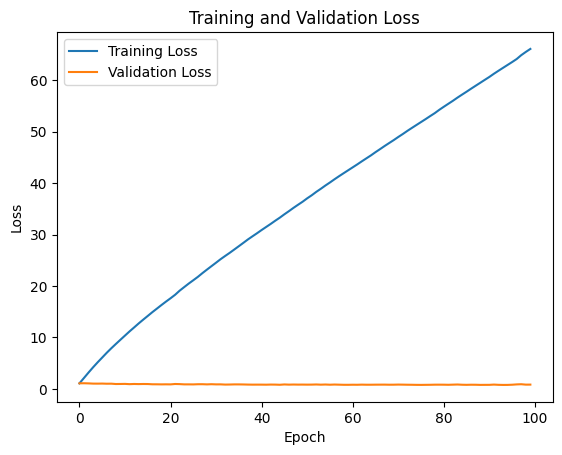

In [33]:
# Plot losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

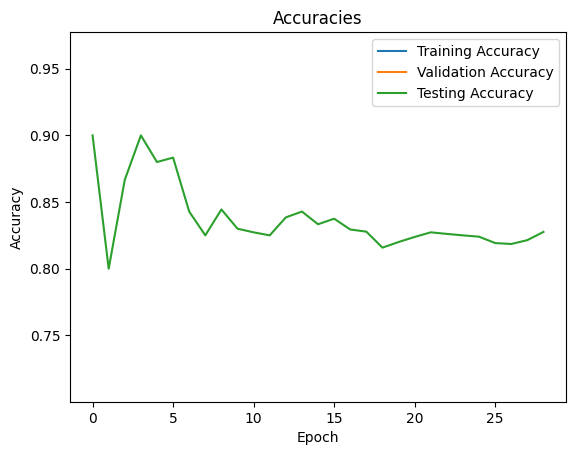

In [34]:
# Plot losses
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Validation Accuracy')
plt.plot(new_testing_accuracy, label='Testing Accuracy')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
net_copy.eval()

pred_scores = []
pred_label_index = []

for i in range(0, len(input_img)):
  output = net_copy(torchvision.transforms.functional.rgb_to_grayscale(input_img[i].to(device)))
  # output = net_copy(input_img[i].type(torch.FloatTensor).to(device))
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, k=1)
  pred_scores.append(prediction_score)
  pred_label_index.append(pred_label_idx)
  print(f"Predicted Score: {prediction_score.squeeze().item()}")
  print(f"Predicted Label: {pred_label_idx.squeeze().item()}")

Predicted Score: 0.5761168599128723
Predicted Label: 1
Predicted Score: 0.5761168599128723
Predicted Label: 1
Predicted Score: 0.5761168599128723
Predicted Label: 1
Predicted Score: 0.5761168599128723
Predicted Label: 1
Predicted Score: 0.5761168599128723
Predicted Label: 1
Predicted Score: 0.5761168599128723
Predicted Label: 1


In [36]:
named_layers = dict(net_copy.named_modules())
named_layers

{'': CNN(
   (features): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
     (1): ReLU()
     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (3): Sequential(
       (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (4): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (5): Sequential(
       (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (6): Sequential(
       (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, st

In [37]:
# Print all the CNN Layers from our trained model.

for name, layer in named_layers.items():
  if isinstance(layer, nn.Conv2d):
    print(name)

features.0
features.3.0
features.4.0
features.5.0
features.6.0
features.7.0


In [38]:
def LayerGradCams(models, features_layers):

  models.eval()  # Enable gradients
  for param in models.parameters():
      param.requires_grad = True

  for i in range(0, len(features_layers)):
    if features_layers[i] == 0:
      target_layer = models.features[0]
    else:
      target_layer = models.features[features_layers[i]][0]
     # Skip non-convolutional layers
    if not isinstance(target_layer, nn.Conv2d):
        print(f"Skipping non-conv layer: {target_layer}")
        continue

    # Register hooks
    def forward_hook(module, input, output):
      print(f"Layer {i} activations - Min: {output.min()}, Max: {output.max()}")

    def backward_hook(module, grad_input, grad_output):
      print(f"Layer {i} gradients - Min: {grad_output[0].min()}, Max: {grad_output[0].max()}")

    fwd_hook = target_layer.register_forward_hook(forward_hook)
    bwd_hook = target_layer.register_backward_hook(backward_hook)

    layer_gradcam = LayerGradCam(models, target_layer)
    print(f"Layer {i}: {target_layer}")  # Check if layer is Conv2d

    for j in range(0, len(input_img)):
      input_tensor = input_img[j].clone().detach().to(device).requires_grad_(True)

      # Check model prediction
      with torch.no_grad():
        logits = models(input_tensor)
        predicted_class = logits.argmax(dim=1).item()
        print(f"Image {j} | Target: {pred_label_index[j]} | Predicted: {predicted_class}")

      # Compute attributions
      try:
          attributions_lgc = layer_gradcam.attribute(
            input_tensor,
            target=pred_label_index[j]
          )
      except Exception as e:
          print(f"Error computing attributions: {e}")
          continue

      # Check for zero attributions
      if torch.all(attributions_lgc == 0):
        print(f"Skipping layer {i}, image {j}: Zero attributions!")
        continue

      print("Attributions min/max:", attributions_lgc.min().item(), attributions_lgc.max().item())
      print(attributions_lgc.squeeze().unsqueeze(2).shape)
      print(torch.from_numpy(original_img[j]).unsqueeze(1).permute(0,2,1).shape)
      # attributions_lgc = attributions_lgc.squeeze().unsqueeze(2).cpu().detach().numpy() # returns a [400, 400, 1] numpy array

      # Normalize with epsilon to avoid division by zero
      attributions_lgc = (attributions_lgc - attributions_lgc.min()) / \
                          (attributions_lgc.max() - attributions_lgc.min() + 1e-8)

      upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img[j].shape[2:])
      upsamp_attr_np = upsamp_attr_lgc[0].cpu().detach().numpy()
      upsamp_attr_np = np.transpose(upsamp_attr_np, (1, 2, 0))
      print(upsamp_attr_np.shape)
      # upsamp_attr_np = np.repeat(upsamp_attr_np, 3, axis=2)

      print(f"Feature Layer no: {features_layers[i]}")


      _ = viz.visualize_image_attr_multiple(upsamp_attr_np, \
                                          new_img[j].permute(1,2,0).numpy(), \
                                          # original_img[j], \
                                          methods=["original_image","heat_map"], \
                                          signs=["all","all"], \
                                          # cmap=plt.colormaps.get_cmap('plasma'), \
                                          cmap=plt.cm.plasma, \
                                          show_colorbar = True, \
                                          fig_size=(6, 5))

      fwd_hook.remove()  # Remove debug hook
      bwd_hook.remove()  # Remove debug hook


In [39]:
features_layers = [0, 3, 4, 5, 6]
LayerGradCams(net_copy, features_layers)

Output hidden; open in https://colab.research.google.com to view.

Attributions shape: (400, 400, 1)
Original image shape: (400, 400)


AssertionError: Cannot normalize by scale factor = 0

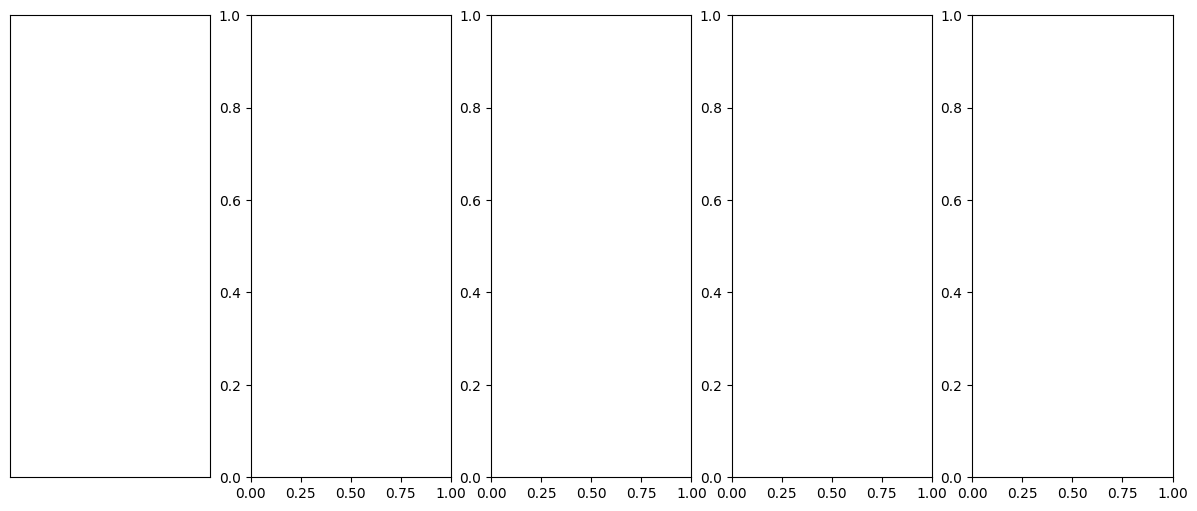

In [41]:
for i in range(0, len(input_img)):
  occlusion = Occlusion(net_copy)
  input_tensor = input_img[i].clone().detach().to(device).requires_grad_(True)

  attributions_occ = occlusion.attribute(
      input_tensor,
      target=pred_label_idx[0],
      strides=(1, 8, 8),
      sliding_window_shapes=(1, 15, 15),
      baselines=0
  )

  # Convert to numpy and reshape
  attributions_np = attributions_occ.squeeze().cpu().detach().numpy()
  attributions_np = np.expand_dims(attributions_np, axis=2)  # Add channel dim
  attributions_np = np.transpose(attributions_np, (1, 0, 2))  # [H, W, C]

  # Verify shapes
  print("Attributions shape:", attributions_np.shape)  # Should be (400, 400, 1)
  print("Original image shape:", original_img[i].shape)  # Should be (400, 400, 3)

  # Visualize
  _,axis = viz.visualize_image_attr_multiple(
      attributions_np,
      # original_img[i],
      new_img[i].permute(1,2,0).numpy(),
      ["original_image", "heat_map", "heat_map",'blended_heat_map', "masked_image"],
      ["all", "positive", "negative", "positive", "positive"],
      show_colorbar=True,
      titles=["Original", "Positive Attribution", "Negative Attribution", 'Blended Masked Image', "Masked"],
      cmap=plt.cm.plasma,
      fig_size=(15, 6)
  )

  _.savefig(f"/content/drive/MyDrive/thesis/Datasets/occulsion_sensitivity/occulsion_sensivitity_{i+1}.png")

In [ ]:
saving_path = "/content/drive/MyDrive/thesis/Model/thesis_proposed_model.pth"

torch.save(net_copy.state_dict(), saving_path)